# Compute on CPU/GPU: Torch Vectors and Operators

@Author: Francesco Picetti - picettifrancesco@gmail.com

In this notebook we will show how to define a new `vector` class based on [PyTorch](https://pytorch.org) operations.

#### Import modules

In [1]:
import numpy as np
import occamypy as o

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'gray',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/nas/home/fpicetti/miniconda3/envs/swung/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## 2D Phantom Deconvolution

In this example we reconstruct a phantom CT image starting from a blurred acquisition.
Again, we regularize the inversion by imposing the first derivative to be sparse.

**Note**: as the vector is instantiated on a GPU, we use the method `plot` for getting a plottable array

In [2]:
x = o.VectorTorch(np.load('./data/shepp_logan_phantom.npy', allow_pickle=True).astype(np.float32),
                  device=5).scale(1 / 255.)
print(x.deviceName)

GPU 5 - TITAN V


The blurring operator is based on torch Conv Modules, so that it handles `torch.Tensor` vector data.
The derivative operator instead is backend-agnostic.

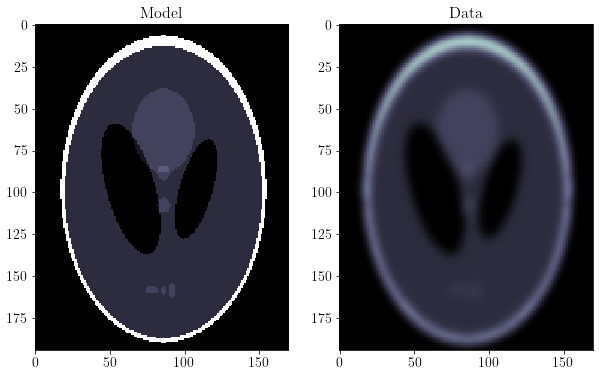

In [3]:
G = o.torch.GaussianFilter(x, sigma=(3.,3.))
d = G * x

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].imshow(x.plot(), cmap='bone', clim=(0,1))
ax[0].grid(False)
ax[0].set_title('Model')
ax[1].imshow(d.plot(), cmap='bone', clim=(0,1))
ax[1].grid(False)
ax[1].set_title('Data')
plt.show()

As regularizer, we compute the gradient.

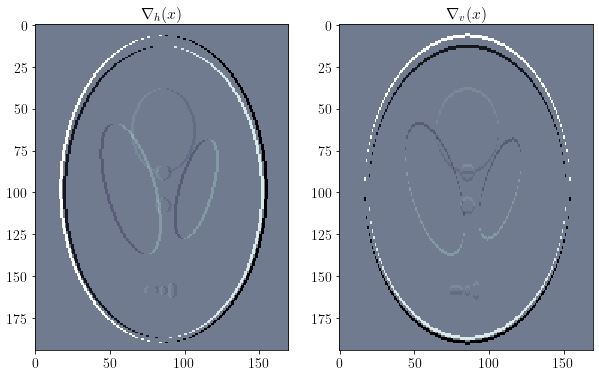

In [4]:
D = o.Gradient(x)
Dx = D * x

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].imshow(Dx.vecs[1].plot(), cmap='bone')
ax[0].grid(False)
ax[0].set_title(r'$\nabla_h(x)$')
ax[1].imshow(Dx.vecs[0].plot(), cmap='bone')
ax[1].grid(False)
ax[1].set_title(r'$\nabla_v(x)$')
plt.show()

Problem and solver:

In [5]:
problemSB = o.GeneralizedLasso(x.clone().zero(), d, G, reg=D, eps=1e-3)
SB = o.SplitBregman(o.BasicStopper(niter=200), niter_inner=3, niter_solver=10,
                           linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True)
SB.run(problemSB, verbose=True, inner_verbose=False)

##########################################################################################
			SPLIT-BREGMAN SOLVER

	Restart folder: /tmp/restart_2022-04-16T23-26-43.417418/
	Modeling Operator:	GausFilt
	Inner iterations:	3
	Solver iterations:	10
	L1 Regularizer op:	Gradient
	L1 Regularizer weight:	1.00e-03
	Bregman update weight:	1.00e+00
	Using warm start option for inner problem
##########################################################################################

iter = 000, obj = 7.21397e+02, df_obj = 7.21e+02, reg_obj = 0.00e+00, resnorm = 3.80e+01
iter = 001, obj = 1.56842e+00, df_obj = 2.37e-02, reg_obj = 1.54e+00, resnorm = 1.26e+01
iter = 002, obj = 1.59997e+00, df_obj = 7.93e-03, reg_obj = 1.59e+00, resnorm = 1.34e+01
iter = 003, obj = 1.61106e+00, df_obj = 4.38e-03, reg_obj = 1.61e+00, resnorm = 1.37e+01
iter = 004, obj = 1.62317e+00, df_obj = 2.92e-03, reg_obj = 1.62e+00, resnorm = 1.39e+01
iter = 005, obj = 1.62704e+00, df_obj = 2.15e-03, reg_obj = 1.62e+00, resnorm 

iter = 088, obj = 1.40879e+00, df_obj = 8.44e-05, reg_obj = 1.41e+00, resnorm = 1.60e+01
iter = 089, obj = 1.40730e+00, df_obj = 8.37e-05, reg_obj = 1.41e+00, resnorm = 1.60e+01
iter = 090, obj = 1.40587e+00, df_obj = 8.29e-05, reg_obj = 1.41e+00, resnorm = 1.60e+01
iter = 091, obj = 1.40443e+00, df_obj = 8.22e-05, reg_obj = 1.40e+00, resnorm = 1.60e+01
iter = 092, obj = 1.40304e+00, df_obj = 8.15e-05, reg_obj = 1.40e+00, resnorm = 1.60e+01
iter = 093, obj = 1.40161e+00, df_obj = 8.09e-05, reg_obj = 1.40e+00, resnorm = 1.60e+01
iter = 094, obj = 1.40024e+00, df_obj = 8.02e-05, reg_obj = 1.40e+00, resnorm = 1.60e+01
iter = 095, obj = 1.39885e+00, df_obj = 7.96e-05, reg_obj = 1.40e+00, resnorm = 1.60e+01
iter = 096, obj = 1.39751e+00, df_obj = 7.89e-05, reg_obj = 1.40e+00, resnorm = 1.60e+01
iter = 097, obj = 1.39615e+00, df_obj = 7.83e-05, reg_obj = 1.40e+00, resnorm = 1.60e+01
iter = 098, obj = 1.39485e+00, df_obj = 7.77e-05, reg_obj = 1.39e+00, resnorm = 1.60e+01
iter = 099, obj = 1.3

iter = 181, obj = 1.32337e+00, df_obj = 5.02e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 182, obj = 1.32286e+00, df_obj = 5.00e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 183, obj = 1.32230e+00, df_obj = 4.98e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 184, obj = 1.32179e+00, df_obj = 4.96e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 185, obj = 1.32124e+00, df_obj = 4.94e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 186, obj = 1.32075e+00, df_obj = 4.92e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 187, obj = 1.32021e+00, df_obj = 4.91e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 188, obj = 1.31973e+00, df_obj = 4.89e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 189, obj = 1.31921e+00, df_obj = 4.87e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 190, obj = 1.31873e+00, df_obj = 4.85e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 191, obj = 1.31821e+00, df_obj = 4.84e-05, reg_obj = 1.32e+00, resnorm = 1.67e+01
iter = 192, obj = 1.3

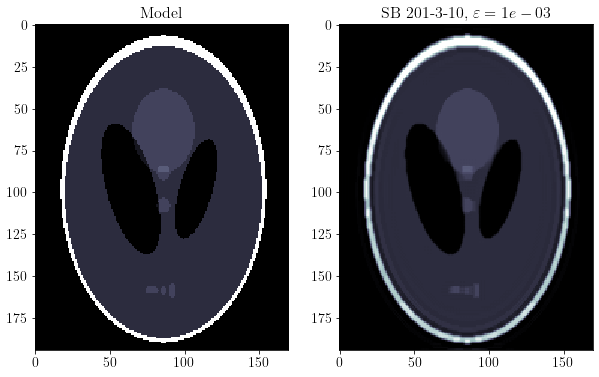

In [6]:
its = "%d-%d-%d" % (len(SB.obj), SB.niter_inner, SB.niter_solver)

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].imshow(x.plot(), cmap='bone', clim=(0,1))
ax[0].grid(False)
ax[0].set_title('Model')
ax[1].imshow(problemSB.model.plot(), cmap='bone', clim=(0,1))
ax[1].grid(False)
ax[1].set_title(r'SB %s, $\varepsilon=%.e$' % (its, problemSB.eps))
plt.show()

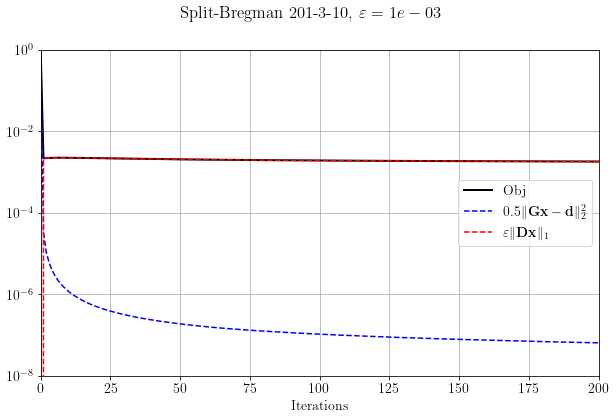

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.semilogy(SB.obj / SB.obj[0], 'k', lw=2, label='Obj')
ax.semilogy(SB.obj_terms[:, 0] / SB.obj[0], 'b--', label=r"$0.5 \Vert \mathbf{Gx-d} \Vert_2^2$")
ax.semilogy(SB.obj_terms[:, 1] / SB.obj[0], 'r--', label=r"$\varepsilon \Vert \mathbf{Dx}\Vert_1$")
ax.set_ylim(1e-8, 1), ax.set_xlim(0, SB.stopper.niter)
ax.set_xlabel("Iterations")
ax.legend(loc="right")
ax.grid(True)
plt.suptitle(r'Split-Bregman %s, $\varepsilon=%.e$' % (its, problemSB.eps))
plt.show()